In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
from util import read_json_from, write_json_to
from data import proteomeHD_df
from visualization_util import df_roc_analysis,df_precision_recall_analysis
from validation import validate_relations_in_df,full_report_calculation_by_size,simplifed_report_df,is_corum_verifiable
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")
RANDOM_STATE = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
prohd_ratios_min95_path = f"{PATH_ROOT}/data_sources/ProteomeHD/prohd_ratios_min95.csv"
prohd_ratios_min95_df = pd.read_csv(prohd_ratios_min95_path)
prohd_ratios_min95_df_simplified_id = prohd_ratios_min95_df['Simplified_protein_ID'].to_numpy()
prohd_ratios_min95_df_feature_matrix = prohd_ratios_min95_df.iloc[:,2:].fillna(0).to_numpy()
prohd_ratios_min95_df_lookup = {prohd_ratios_min95_df_simplified_id[i]:i for i in range(len(prohd_ratios_min95_df_simplified_id))}
proHD_cols = [col for col in proteomeHD_df.columns if 'Ratio' in col]

NameError: name 'PATH_ROOT' is not defined

In [3]:
proteomeHD_combined_pairs_df = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_balanced_pos_neg_pairs_combined.csv")

In [19]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(proteomeHD_combined_pairs_df,test_size=0.2,random_state=RANDOM_STATE)

train_features = train_data[proHD_cols].to_numpy()
train_binary_interaction_labels = train_data['binary_interaction'].to_numpy()
train_cocomplex_interaction_labels = train_data['cocomplex'].to_numpy()

test_features = test_data[proHD_cols].to_numpy()
test_binary_interaction_labels = test_data['binary_interaction'].to_numpy()
test_cocomplex_interaction_labels = test_data['cocomplex'].to_numpy()

In [20]:
from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(random_state=RANDOM_STATE)
logistic_clf.fit(train_features,train_binary_interaction_labels)
logistic_clf_pred = logistic_clf.predict_proba(test_features)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
from sklearn.svm import SVC
svc_clf = SVC(random_state=RANDOM_STATE,probability=True)
svc_clf.fit(train_features,train_binary_interaction_labels)
svc_clf_pred = svc_clf.predict_proba(test_features)

In [ ]:
# Try using classifier on unstratified sampling on total pairs
# temp_test_features = proteomeHD_combined_pairs_df.sample()
# svc_clf.predict_proba()

In [138]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=RANDOM_STATE,hidden_layer_sizes=(256,256),early_stopping=True)
mlp_clf.fit(train_features,train_binary_interaction_labels)
mlp_clf_pred = mlp_clf.predict_proba(test_features)

In [182]:
from sklearn.neural_network import MLPClassifier
mlp_clf_big = MLPClassifier(random_state=RANDOM_STATE,hidden_layer_sizes=(512,256,256,128),early_stopping=True)
mlp_clf_big.fit(train_features,train_binary_interaction_labels)
mlp_clf_big_pred = mlp_clf_big.predict_proba(test_features)

In [214]:
from sklearn.neural_network import MLPClassifier
mlp_clf_deep = MLPClassifier(random_state=RANDOM_STATE,hidden_layer_sizes=(1024,1024),early_stopping=True)
mlp_clf_deep.fit(train_features,train_binary_interaction_labels)
mlp_clf_deep_pred = mlp_clf_deep.predict_proba(test_features)

In [213]:
import pickle
mlp_file_name = 'mlp_model_512_256_256_128.sav'
pickle.dump(mlp_clf_big, open(mlp_file_name, 'wb'))

In [44]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost_tree_clf = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
ada_boost_tree_clf.fit(train_features, train_binary_interaction_labels)
ada_boost_clf_pred = ada_boost_tree_clf.predict_proba(test_features)

In [170]:
mlp_clf_big_pred[:,1]

array([0.99966042, 0.24964417, 0.94176987, ..., 0.99922863, 0.05530482,
       0.13509883])

In [215]:
results = [test_data['coregulation_score'],
           logistic_clf_pred[:,1],
           ada_boost_clf_pred[:,1],
           svc_clf_pred[:,1],
           mlp_clf_pred[:,1],
           mlp_clf_big_pred[:,1],
           mlp_clf_deep_pred[:,1],
           test_binary_interaction_labels,
           test_cocomplex_interaction_labels]
result_cols = ['coregulation_score',
               'logistic_score',
               'ada_boost_score',
               'svc_score',
               'mlp_score',
               'mlp_big_score',
               'mlp_deep_score',
               'binary_interaction',
               'cocomplex']
scores_to_check = ['coregulation_score','logistic_score','ada_boost_score','svc_score','mlp_score','mlp_big_score','mlp_deep_score']
results = np.array(results).T
summary_df = pd.DataFrame(columns=result_cols,data=results)

In [24]:
summary_df

,coregulation_score,logistic_score,binary_interaction,cocomplex
0,0.003438,0.344004,1.0,0.0
1,0.001381,0.720562,0.0,0.0
2,0.000224,0.314141,1.0,0.0
3,0.004693,0.189409,0.0,0.0
4,0.002940,0.323312,0.0,0.0
...,...,...,...,...
19995,0.002859,0.443964,1.0,1.0
19996,0.002137,0.734487,0.0,0.0
19997,0.000493,0.288888,0.0,0.0
19998,0.000041,0.631276,1.0,0.0


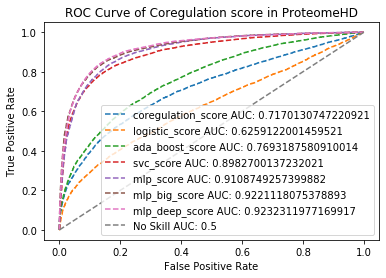

[0.7170130747220921,
 0.6259122001459521,
 0.7693187580910014,
 0.8982700137232021,
 0.9108749257399882,
 0.9221118075378893,
 0.9232311977169917,
 0.5]

In [216]:
df_roc_analysis(summary_df,scores_to_check,'binary_interaction','ROC Curve of Coregulation score in ProteomeHD')

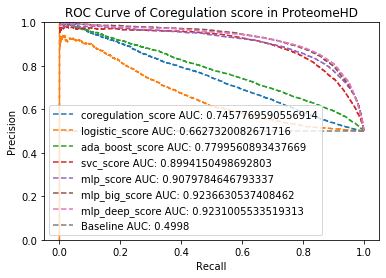

[0.7457769590556914,
 0.6627320082671716,
 0.7799560893437669,
 0.8994150498692803,
 0.9079784646793337,
 0.9236630537408462,
 0.9231005533519313,
 0.4998]

In [217]:
df_precision_recall_analysis(summary_df,scores_to_check,'binary_interaction','ROC Curve of Coregulation score in ProteomeHD',ylim=(0,1))

In [76]:
from sklearn.linear_model import LogisticRegression
logistic_cocomplex_clf = LogisticRegression(random_state=RANDOM_STATE)
logistic_cocomplex_clf.fit(train_features,train_cocomplex_interaction_labels)
logistic_cocomplex_clf_pred = logistic_cocomplex_clf.predict_proba(test_features)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [77]:
from sklearn.neural_network import MLPClassifier
mlp_cocomplex_clf = MLPClassifier(random_state=RANDOM_STATE,hidden_layer_sizes=(256,256),early_stopping=True)
mlp_cocomplex_clf.fit(train_features,train_cocomplex_interaction_labels)
mlp_cocomplex_clf_pred = mlp_cocomplex_clf.predict_proba(test_features)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_cocomplex_clf_big = MLPClassifier(random_state=RANDOM_STATE,hidden_layer_sizes=(1,),early_stopping=True)
mlp_cocomplex_clf_big.fit(train_features,train_cocomplex_interaction_labels)
mlp_cocomplex_clf_big_pred = mlp_cocomplex_clf_big.predict_proba(test_features)

In [78]:
cocomplex_results = [test_data['coregulation_score'],
           logistic_cocomplex_clf_pred[:,1],
           mlp_cocomplex_clf_pred[:,1],
           test_binary_interaction_labels,
           test_cocomplex_interaction_labels]
cocomplex_result_cols = ['coregulation_score',
               'logistic_score',
               'mlp_score',
               'binary_interaction',
               'cocomplex']
cocomplex_scores_to_check = ['coregulation_score','logistic_score','mlp_score']
cocomplex_results_T = np.array(cocomplex_results).T
cocomplex_summary_df = pd.DataFrame(columns=cocomplex_result_cols,data=cocomplex_results_T)

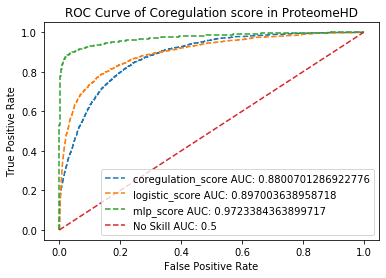

[0.8800701286922776, 0.897003638958718, 0.9723384363899717, 0.5]

In [81]:
df_roc_analysis(cocomplex_summary_df,cocomplex_scores_to_check,'cocomplex','ROC Curve of Coregulation score in ProteomeHD')

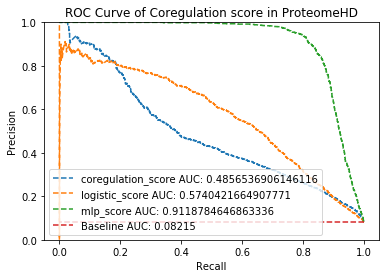

[0.4856536906146116, 0.5740421664907771, 0.9118784646863336, 0.08215]

In [89]:
df_precision_recall_analysis(cocomplex_summary_df,cocomplex_scores_to_check,'cocomplex','ROC Curve of Coregulation score in ProteomeHD',ylim=(0,1),legend_placement="lower left")

In [92]:
coreg_score_simplified = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/coregulation_scores_simplified.csv")
coreg_score_simplified_sampled = coreg_score_simplified.sample(100000,random_state=RANDOM_STATE)
coreg_score_simplified_sampled

,protein_1,protein_2,coregulation_score
4018292,Q6YHK3,P25774,0.000003
4371181,Q86TU7,P07686,0.000512
5298224,Q8TBC4,Q14697,0.000074
5810501,Q92688,P51570,0.000142
1887329,Q00059,P04844,0.000289
...,...,...,...
11586578,Q9Y2R5,P56192,0.008517
11681990,Q9Y2Z9,P00973,0.000071
3445466,Q5JPH6,P49137,0.000083
9648170,Q9NVU7,P28288,0.000034


In [93]:
from validation import validate_relations_in_df
validated_unstratified_df = validate_relations_in_df(coreg_score_simplified_sampled,timed=True)

Current Index: 9580001, ETA: -3.89393139712452
Current Index: 11830001, ETA: -3.9057100474110262
Current Index: 750001, ETA: -3.5351402540661785
Current Index: 4350001, ETA: -4.1962460629762095
Current Index: 12360001, ETA: -4.293957281014329
Current Index: 8580001, ETA: -6.288845920091837
Current Index: 10520001, ETA: -6.39364746308961
Current Index: 7400001, ETA: -7.19343812444106
Current Index: 3520001, ETA: -8.295424822877381
Current Index: 6960001, ETA: -10.062297476270535
Current Index: 5330001, ETA: -11.139976567819138
Current Index: 12080001, ETA: -12.528404595019614
Current Index: 1030001, ETA: -11.527468736631839
Current Index: 7320001, ETA: -13.311607091586744


In [96]:
np.sum(validated_unstratified_df['binary_interaction'].to_numpy())

777

In [99]:
import time
from util import calc_eta
chungus = []
starttime=time.time()
for idx,row in validated_unstratified_df.iterrows():
    p1 = row['protein_1']
    p2 = row['protein_2']
    vec_1 = prohd_ratios_min95_df_feature_matrix[prohd_ratios_min95_df_lookup[p1]]
    vec_2 = prohd_ratios_min95_df_feature_matrix[prohd_ratios_min95_df_lookup[p2]]
    comb_vec = vec_1+vec_2
    chungus.append(comb_vec)
    if idx % 10000 == 1:
        calc_eta(starttime,idx,len(validated_unstratified_df))
big_chungus = pd.DataFrame(columns=proHD_cols,data=chungus)

ETA: -0.6877468889199735 seconds
ETA: -0.6940847792431636 seconds
ETA: -0.7418680123361042 seconds
ETA: -1.0659207889510391 seconds
ETA: -1.1198665914086476 seconds
ETA: -3.300113362399774 seconds
ETA: -3.4142636250505074 seconds
ETA: -4.3928246353895295 seconds
ETA: -5.745051712107633 seconds
ETA: -8.421247888395406 seconds
ETA: -9.697578262778059 seconds
ETA: -10.911917955710317 seconds
ETA: -10.083730268886205 seconds
ETA: -11.717705288243256 seconds


In [104]:
p1s = coreg_score_simplified_sampled_index_reset['protein_1'].to_numpy()
p2s = coreg_score_simplified_sampled_index_reset['protein_2'].to_numpy()
combp1p2 = [p1s[i]+'-'+p2s[i] for i in range(len(p1s))]
coreg_score_simplified_sampled_index_reset.insert(0,'combined_name',combp1p2)
coreg_score_simplified_sampled_index_reset

,combined_name,protein_1,protein_2,coregulation_score
0,Q6YHK3-P25774,Q6YHK3,P25774,0.000003
1,Q86TU7-P07686,Q86TU7,P07686,0.000512
2,Q8TBC4-Q14697,Q8TBC4,Q14697,0.000074
3,Q92688-P51570,Q92688,P51570,0.000142
4,Q00059-P04844,Q00059,P04844,0.000289
...,...,...,...,...
99995,Q9Y2R5-P56192,Q9Y2R5,P56192,0.008517
99996,Q9Y2Z9-P00973,Q9Y2Z9,P00973,0.000071
99997,Q5JPH6-P49137,Q5JPH6,P49137,0.000083
99998,Q9NVU7-P28288,Q9NVU7,P28288,0.000034


In [105]:
biggest_chungus = pd.concat([coreg_score_simplified_sampled_index_reset, big_chungus], axis=1)
biggest_chungus

,combined_name,protein_1,protein_2,coregulation_score,RatioHL_GK1_Chromatin_AL,RatioHL_GK1_Chromatin_CPT,RatioHL_GK1_Chromatin_CR,RatioHL_GK1_Chromatin_HepHek,RatioHL_GK1_Chromatin_hiIR,RatioHL_GK1_Chromatin_loIR,...,RatioHL_PX441_E1,RatioHL_PX441_E2,RatioHL_PX441_E3,RatioHL_PX441_E4,RatioHL_PX441_E5,RatioHL_PX441_F1,RatioHL_PX441_F2,RatioHL_PX441_F3,RatioHL_PX441_F4,RatioHL_PX441_F5
0,Q6YHK3-P25774,Q6YHK3,P25774,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.481973,0.322124,1.449416,0.412446,-0.417600,-0.675171,-0.889236,-0.470880,-1.198252,1.375343
1,Q86TU7-P07686,Q86TU7,P07686,0.000512,0.000000,0.000000,0.000000,0.561004,0.000000,0.000000,...,2.341021,0.118223,2.511442,0.590879,-0.553512,-0.394457,-1.481181,-0.541095,-1.235251,1.068720
2,Q8TBC4-Q14697,Q8TBC4,Q14697,0.000074,-0.757654,1.717237,-0.683186,0.750197,-0.650741,-0.238301,...,0.565529,-0.236258,-0.483662,-0.233621,0.030753,-0.552228,-0.143443,-0.015903,0.629654,-0.124963
3,Q92688-P51570,Q92688,P51570,0.000142,-0.247395,0.192053,-0.432185,0.217953,0.394799,-0.106220,...,0.861185,-1.292335,0.803082,-0.501989,0.161516,0.976769,-0.335954,1.420498,-0.364368,-0.351232
4,Q00059-P04844,Q00059,P04844,0.000289,-0.448570,1.744610,-0.534096,1.153329,0.000000,-0.032607,...,0.209843,0.003771,-0.750093,0.758201,1.047969,-0.743419,0.404192,0.210762,1.340578,-1.083175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Q9Y2R5-P56192,Q9Y2R5,P56192,0.008517,-0.554830,0.425023,-0.401021,3.939647,-0.164687,0.187478,...,-0.584194,-0.513974,-0.488922,0.013489,0.832055,0.154523,2.455158,0.350740,1.339390,-1.671364
99996,Q9Y2Z9-P00973,Q9Y2Z9,P00973,0.000071,0.313829,-0.613469,0.257211,-0.945405,0.359678,-0.007410,...,-0.043112,-0.203898,-1.049750,-0.089761,0.205351,-0.077115,0.166598,-0.021791,0.197856,-0.508133
99997,Q5JPH6-P49137,Q5JPH6,P49137,0.000083,0.000000,0.000000,0.000000,0.000000,-0.272715,0.000000,...,-0.728576,0.000000,0.000000,-0.267118,0.000000,0.681258,0.000000,0.000000,0.000000,0.000000
99998,Q9NVU7-P28288,Q9NVU7,P28288,0.000034,-2.124939,0.118869,-1.677443,2.586488,0.201378,-0.084956,...,-0.788830,0.089098,-1.043093,-1.299203,0.000000,0.671620,2.732884,-1.400612,0.184408,0.712944


In [109]:
b_interactions = validated_unstratified_df['binary_interaction'].to_numpy()
cocomplex_interactions = validated_unstratified_df['cocomplex'].to_numpy()

In [110]:
biggest_chungus.insert(3,'binary_interaction',b_interactions)
biggest_chungus.insert(4,'cocomplex',cocomplex_interactions)
biggest_chungus

,combined_name,protein_1,protein_2,binary_interaction,cocomplex,coregulation_score,RatioHL_GK1_Chromatin_AL,RatioHL_GK1_Chromatin_CPT,RatioHL_GK1_Chromatin_CR,RatioHL_GK1_Chromatin_HepHek,...,RatioHL_PX441_E1,RatioHL_PX441_E2,RatioHL_PX441_E3,RatioHL_PX441_E4,RatioHL_PX441_E5,RatioHL_PX441_F1,RatioHL_PX441_F2,RatioHL_PX441_F3,RatioHL_PX441_F4,RatioHL_PX441_F5
0,Q6YHK3-P25774,Q6YHK3,P25774,0,0,0.000003,0.000000,0.000000,0.000000,0.000000,...,0.481973,0.322124,1.449416,0.412446,-0.417600,-0.675171,-0.889236,-0.470880,-1.198252,1.375343
1,Q86TU7-P07686,Q86TU7,P07686,0,0,0.000512,0.000000,0.000000,0.000000,0.561004,...,2.341021,0.118223,2.511442,0.590879,-0.553512,-0.394457,-1.481181,-0.541095,-1.235251,1.068720
2,Q8TBC4-Q14697,Q8TBC4,Q14697,0,0,0.000074,-0.757654,1.717237,-0.683186,0.750197,...,0.565529,-0.236258,-0.483662,-0.233621,0.030753,-0.552228,-0.143443,-0.015903,0.629654,-0.124963
3,Q92688-P51570,Q92688,P51570,0,0,0.000142,-0.247395,0.192053,-0.432185,0.217953,...,0.861185,-1.292335,0.803082,-0.501989,0.161516,0.976769,-0.335954,1.420498,-0.364368,-0.351232
4,Q00059-P04844,Q00059,P04844,0,0,0.000289,-0.448570,1.744610,-0.534096,1.153329,...,0.209843,0.003771,-0.750093,0.758201,1.047969,-0.743419,0.404192,0.210762,1.340578,-1.083175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Q9Y2R5-P56192,Q9Y2R5,P56192,0,0,0.008517,-0.554830,0.425023,-0.401021,3.939647,...,-0.584194,-0.513974,-0.488922,0.013489,0.832055,0.154523,2.455158,0.350740,1.339390,-1.671364
99996,Q9Y2Z9-P00973,Q9Y2Z9,P00973,0,0,0.000071,0.313829,-0.613469,0.257211,-0.945405,...,-0.043112,-0.203898,-1.049750,-0.089761,0.205351,-0.077115,0.166598,-0.021791,0.197856,-0.508133
99997,Q5JPH6-P49137,Q5JPH6,P49137,0,0,0.000083,0.000000,0.000000,0.000000,0.000000,...,-0.728576,0.000000,0.000000,-0.267118,0.000000,0.681258,0.000000,0.000000,0.000000,0.000000
99998,Q9NVU7-P28288,Q9NVU7,P28288,0,0,0.000034,-2.124939,0.118869,-1.677443,2.586488,...,-0.788830,0.089098,-1.043093,-1.299203,0.000000,0.671620,2.732884,-1.400612,0.184408,0.712944


In [111]:
biggest_chungus.to_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_unstratified_pairs_combined.csv",index=False)

In [113]:
unstratified_features = biggest_chungus[proHD_cols].to_numpy()
unstratified_binary_interaction_labels = biggest_chungus['binary_interaction'].to_numpy()
unstratified_cocomplex_interaction_labels = biggest_chungus['cocomplex'].to_numpy()

In [119]:
unstratified_mlp_binary_interaction_pred = mlp_clf.predict_proba(unstratified_features)
unstratified_logistic_clf_binary_interaction_pred = logistic_clf.predict_proba(unstratified_features)
unstratified_svc_clf_binary_interaction_pred = svc_clf.predict_proba(unstratified_features)

In [218]:
unstratified_mlp_big_binary_interaction_pred = mlp_clf_big.predict_proba(unstratified_features)
unstratified_mlp_deep_binary_interaction_pred = mlp_clf_deep.predict_proba(unstratified_features)

In [219]:
unstratified_binary_results = [biggest_chungus['coregulation_score'],
           unstratified_logistic_clf_binary_interaction_pred[:,1],
           unstratified_svc_clf_binary_interaction_pred[:,1],
           unstratified_mlp_binary_interaction_pred[:,1],
           unstratified_mlp_big_binary_interaction_pred[:,1],
           unstratified_mlp_deep_binary_interaction_pred[:,1],
           unstratified_binary_interaction_labels,
           unstratified_cocomplex_interaction_labels]
unstratified_binary_result_cols = ['coregulation_score',
               'logistic_score',
               'svc_score',
               'mlp_score',
               'mlp_big_score',
               'mlp_deep_score',
               'binary_interaction',
               'cocomplex']
unstratified_binary_scores_to_check = ['coregulation_score','logistic_score','svc_score','mlp_score','mlp_big_score','mlp_deep_score']
unstratified_binary_results_T = np.array(unstratified_binary_results).T
unstratified_binary_summary_df = pd.DataFrame(columns=unstratified_binary_result_cols,data=unstratified_binary_results_T)

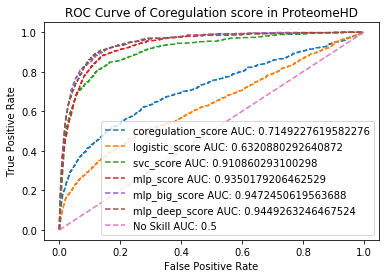

[0.7149227619582276,
 0.6320880292640872,
 0.910860293100298,
 0.9350179206462529,
 0.9472450619563688,
 0.9449263246467524,
 0.5]

In [220]:
df_roc_analysis(unstratified_binary_summary_df,unstratified_binary_scores_to_check,'binary_interaction','ROC Curve of Coregulation score in ProteomeHD')

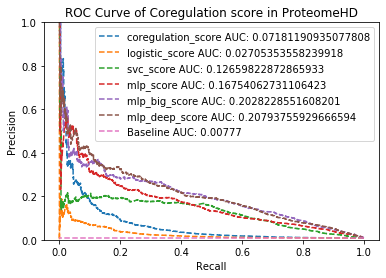

[0.07181190935077808,
 0.02705353558239918,
 0.12659822872865933,
 0.16754062731106423,
 0.2028228551608201,
 0.20793755929666594,
 0.00777]

In [221]:
df_precision_recall_analysis(unstratified_binary_summary_df,unstratified_binary_scores_to_check,'binary_interaction','ROC Curve of Coregulation score in ProteomeHD',ylim=(0,1))

In [115]:
unstratified_mlp_cocomplex_clf_pred = mlp_cocomplex_clf.predict_proba(unstratified_features)
unstratified_logistic_cocomplex_clf_pred = logistic_cocomplex_clf.predict_proba(unstratified_features)

In [124]:
unstratified_cocomplex_results = [biggest_chungus['coregulation_score'],
           unstratified_logistic_cocomplex_clf_pred[:,1],
           unstratified_mlp_cocomplex_clf_pred[:,1],
           unstratified_binary_interaction_labels,
           unstratified_cocomplex_interaction_labels]
unstratified_cocomplex_result_cols = ['coregulation_score',
               'logistic_score',
               'mlp_score',
               'binary_interaction',
               'cocomplex']
unstratified_cocomplex_scores_to_check = ['coregulation_score','logistic_score','mlp_score']
unstratified_cocomplex_results_T = np.array(unstratified_cocomplex_results).T
unstratified_cocomplex_summary_df = pd.DataFrame(columns=unstratified_cocomplex_result_cols,data=unstratified_cocomplex_results_T)

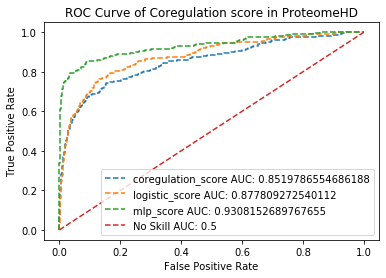

[0.8519786554686188, 0.877809272540112, 0.9308152689767655, 0.5]

In [125]:
df_roc_analysis(unstratified_cocomplex_summary_df,unstratified_cocomplex_scores_to_check,'cocomplex','ROC Curve of Coregulation score in ProteomeHD')

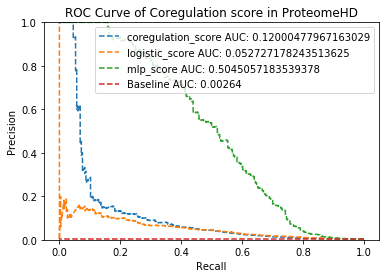

[0.12000477967163029, 0.052727178243513625, 0.5045057183539378, 0.00264]

In [126]:
df_precision_recall_analysis(unstratified_cocomplex_summary_df,unstratified_cocomplex_scores_to_check,'cocomplex','ROC Curve of Coregulation score in ProteomeHD',ylim=(0,1))

In [134]:
not_confident_correct_1 = unstratified_mlp_cocomplex_clf_pred[:,1] <= 0.6
not_confident_correct_2 = unstratified_mlp_cocomplex_clf_pred[:,1] >= 0.4
np.sum(np.sum(np.logical_and(not_confident_correct_1,not_confident_correct_2)))

143

In [136]:
confident_correct = unstratified_mlp_cocomplex_clf_pred[:,1] >= 0.75
np.sum(confident_correct)

501

In [ ]:
# from util import calc_eta
# import time
# starttime = time.time()
# r_values = []
# for i in range(len(p1s)):
#     p1 = p1s[i]
#     p2 = p2s[i]
#     vec1 = prohd_ratios_min95_df_feature_matrix[prohd_ratios_min95_df_lookup[p1]]
#     vec2 = prohd_ratios_min95_df_feature_matrix[prohd_ratios_min95_df_lookup[p2]]
#     shared = ~np.logical_or(np.isnan(vec1), np.isnan(vec2))
#     if np.sum(shared) < 3:
#         r_values.append(float('NaN'))
#     else:
#         r = np.corrcoef(vec1[shared],vec2[shared])[0,1]
#         r_values.append(r)
#     if i%10000 == 1 and i>1:
#         calc_eta(starttime,i,len(p1s))